# 序列模型

## 1. 统计工具

+ 自回归模型
    + 第⼀种策略，假设在现实情况下相当⻓的序列 x<sub>t−1</sub>, . . . , x1可能是不必要的，因此我们只需要满⾜某个⻓度为τ的时间跨度，即使⽤观测序列x<sub>t−1</sub>, . . . , x<sub>t−τ</sub>。当下获得的最直接的好处就是参数的数量总是不变的，⾄少在t > τ时如此，这就使我们能够训练⼀个上⾯提及的深度⽹络。这种模型被称为⾃回归模型（autoregressivemodels），因为它们是对⾃⼰执⾏回归。
    + 第⼆种策略，如 图8.1.2所⽰，是保留⼀些对过去观测的总结ht，并且同时更新预测xˆt和总结ht。这就产⽣了基于xˆt = P(xt | ht)估计xt，以及公式ht = g(ht−1, xt−1)更新的模型。由于ht从未被观测到，这类模型也被称为 隐变量⾃回归模型（latent autoregressive models）。
    ![](images/hiddensr.png) 
    
    + 这两种情况都有⼀个显⽽易⻅的问题：如何⽣成训练数据？⼀个经典⽅法是使⽤历史观测来预测下⼀个未来观测。显然，我们并不指望时间会停滞不前。然⽽，⼀个常⻅的假设是虽然特定值xt可能会改变，但是序列本⾝的动⼒学不会改变。这样的假设是合理的，因为新的动⼒学⼀定受新的数据影响，⽽我们不可能⽤⽬前所掌握的数据来预测新的动⼒学。统计学家称不变的动⼒学为静⽌的（stationary）


+ 马尔可夫模型
    + 在⾃回归模型的近似法中，我们使⽤xt−1, . . . , xt−τ ⽽不是xt−1, . . . , x1来估计xt。只要这种是近似精确的，我们就说序列满⾜⻢尔可夫条件（Markov condition）。特别是，如果τ = 1，得到⼀个 ⼀阶⻢尔可夫模型（first-order Markov model），
    ![](images/markov.png)

## 2. 训练

⽣成⼀些数据：使⽤正弦函数和⼀些可加性噪声来⽣成序列数据，时间步为1, 2, . . . , 1000。


In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

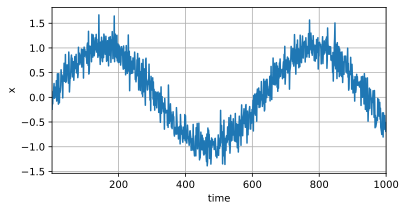

In [2]:
T = 1000 # 产生1000个数据点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T, ))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6,3))

我们将这个序列转换为模型的特征－标签（feature-label）,tau个x对应一个y

In [4]:
tau = 4
features = torch.zeros((T - tau, tau)) # (样本数， 特征数)
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [5]:
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                           batch_size, is_train=True)


In [6]:
def init_weights(m):
    if type(m) == nn.Module:
        nn.init.xavier_uniform_(m.weight)
        
def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction='none')

In [10]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch+1}, '
             f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

In [11]:
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.062719
epoch 2, loss: 0.051876
epoch 3, loss: 0.051246
epoch 4, loss: 0.050596
epoch 5, loss: 0.050942


## 3. 预测

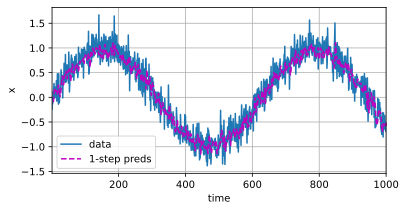

In [12]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
        [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
        'x', legend=['data', '1-step preds'], xlim=[1, 1000],
        figsize=(6,3))

In [13]:
# 基于前tau个数据预测多步数据
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau: i].reshape((1, -1))
    )

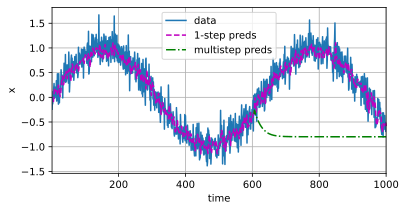

In [14]:
d2l.plot([time, time[tau:], time[n_train + tau:]], 
        [x.detach().numpy(), onestep_preds.detach().numpy(),
        multistep_preds[n_train+tau: ].detach().numpy()], 'time',
        'x', legend=['data', '1-step preds', 'multistep preds'],
        xlim=[1, 1000], figsize=(6, 3))

经过⼏个预测步骤之后，预测的结果很快就会衰减到⼀个常
数。为什么这个算法效果这么差呢？事实是由于错误的累积：假设在步骤1之后，我们积累了⼀些错误ϵ1 = ¯ϵ。于是，步骤2的输⼊被扰动了ϵ1，结果积累的误差是依照次序的ϵ2 = ¯ϵ + cϵ1，其中c为某个常数，后⾯的预测误差依此类推。因此误差可能会相当快地偏离真实的观测结果。例如，未来24⼩时的天⽓预报往往相当准确，
但超过这⼀点，精度就会迅速下降

基于k = 1, 4, 16, 64，通过对整个序列预测的计算，让我们更仔细地看⼀下k步预测的困难。

In [15]:
# step-k: 为通过前tau个数据来预测后k个数据
max_steps = 64

In [16]:
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来⾃x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

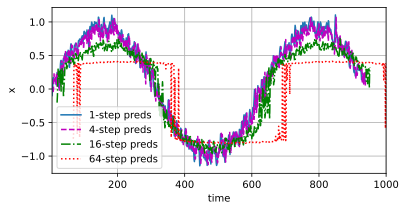

In [18]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
        [features[:, tau + i - 1].detach().numpy() for i in steps], 'time', 'x',
        legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
        figsize=(6,3))

## 总结
+ 内插法（在现有观测值之间进⾏估计）和外推法（对超出已知观测范围进⾏预测）在实践的难度上差别很⼤。因此，对于所拥有的序列数据，在训练时始终要尊重其时间顺序，即最好不要基于未来的数据进⾏训练。
+ 序列模型的估计需要专⻔的统计⼯具，两种较流⾏的选择是⾃回归模型和隐变量⾃回归模型。
+ 对于时间是向前推进的因果模型，正向估计通常⽐反向估计更容易。
+ 对于直到时间步t的观测序列，其在时间步t + k的预测输出是“k步预测”。随着我们对预测时间k值的增加，会造成误差的快速累积和预测质量的极速下降。
